Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)  
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
Повторить п.2, но используя уже не медиану, а max  
(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.  
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score  
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных  

### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

### Переходим к практике

Три ячейки ниже делаем в Google Colaboratory

- установим razdel
- установим pymorphy2

https://drive.google.com/file/d/1QS_1hjvSO5PmH_ChHOwi-U-iE-8UFSVJ/view?usp=sharing
https://drive.google.com/file/d/1EM64ivk98hKY4gkE5nkSQ1Ly39iYMfsg/view?usp=sharing
https://drive.google.com/file/d/1OFowsulpIvUi2hGo55_Cgg5p6NXxSF1I/view?usp=sharing
https://drive.google.com/file/d/1vqw9lKxhIhhiQZML-d0ERBpyorhSmL8a/view?usp=sharing
https://drive.google.com/file/d/1bxtVbd6I9bZUsY6uBfrXa2-eLdC3ZPiH/view?usp=sharing

In [68]:
! gdown --id 1QS_1hjvSO5PmH_ChHOwi-U-iE-8UFSVJ

Downloading...
From: https://drive.google.com/uc?id=1QS_1hjvSO5PmH_ChHOwi-U-iE-8UFSVJ
To: /content/articles.csv
145MB [00:01, 142MB/s]


In [69]:
! gdown --id 1EM64ivk98hKY4gkE5nkSQ1Ly39iYMfsg

Downloading...
From: https://drive.google.com/uc?id=1EM64ivk98hKY4gkE5nkSQ1Ly39iYMfsg
To: /content/articles_idf.csv
100% 368k/368k [00:00<00:00, 53.2MB/s]


In [70]:
! gdown --id 1OFowsulpIvUi2hGo55_Cgg5p6NXxSF1I

Downloading...
From: https://drive.google.com/uc?id=1OFowsulpIvUi2hGo55_Cgg5p6NXxSF1I
To: /content/users_articles.csv
100% 434k/434k [00:00<00:00, 57.4MB/s]


In [71]:
! gdown --id 1vqw9lKxhIhhiQZML-d0ERBpyorhSmL8a

Downloading...
From: https://drive.google.com/uc?id=1vqw9lKxhIhhiQZML-d0ERBpyorhSmL8a
To: /content/users_churn.csv
100% 80.0k/80.0k [00:00<00:00, 27.6MB/s]


In [72]:
! gdown --id 1bxtVbd6I9bZUsY6uBfrXa2-eLdC3ZPiH

Downloading...
From: https://drive.google.com/uc?id=1bxtVbd6I9bZUsY6uBfrXa2-eLdC3ZPiH
To: /content/stopwords.txt
100% 5.37k/5.37k [00:00<00:00, 9.15MB/s]


In [73]:
!pip install razdel

In [74]:
!pip install pymorphy2

Делаем доступ к Googl Drive

In [75]:
import pandas as pd

Наши новости

In [76]:
news = pd.read_csv("/content/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [77]:
users = pd.read_csv("/content/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [78]:
#from gensim.test.utils import common_texts
# https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/
from gensim.corpora.dictionary import Dictionary

In [79]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [80]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [82]:
len(stopword_ru)

151

In [83]:
with open('/content/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [84]:
stopword_ru[100]

'почти'

In [85]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [86]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}



In [87]:
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [88]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

0    заместитель председателяnправительства рфnсерг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [89]:
lemmatization(norm_text[0])[:5]

['заместитель', 'председатель', 'правительство', 'рф', 'сергей']

In [90]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 25.4 s, sys: 573 ms, total: 26 s
Wall time: 26.1 s


In [91]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 26s, sys: 834 ms, total: 4min 27s
Wall time: 4min 27s


А теперь в 3 строчки обучим нашу модель

In [92]:
# #сформируем список наших текстов, разбив еще и на пробелы
# texts = [t for t in news['title'].values]

# # Create a corpus from a list of texts
# common_dictionary = Dictionary(texts)
# common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer

Что такое common_dictionary и как он выглядит

In [93]:
common_dictionary[4]

'армеец'

In [184]:
common_dictionary.id2token

{0: 'nn',
 1: 'александр',
 2: 'алексей',
 3: 'андрей',
 4: 'армеец',
 5: 'банк',
 6: 'баскетбол',
 7: 'близкий',
 8: 'блок',
 9: 'борьба',
 10: 'ватутин',
 11: 'взаимодействие',
 12: 'власть',
 13: 'войти',
 14: 'вячеслав',
 15: 'генералполковник',
 16: 'генеральный',
 17: 'георгий',
 18: 'гмк',
 19: 'директор',
 20: 'европа',
 21: 'единогласно',
 22: 'заместитель',
 23: 'заседание',
 24: 'защита',
 25: 'иванов',
 26: 'избрать',
 27: 'исакович',
 28: 'клиентский',
 29: 'клуб',
 30: 'конституционный',
 31: 'корпоративный',
 32: 'леонид',
 33: 'лопат',
 34: 'министр',
 35: 'мир',
 36: 'начальник',
 37: 'никель',
 38: 'новак',
 39: 'норильский',
 40: 'оао',
 41: 'обсуждение',
 42: 'округ',
 43: 'ольга',
 44: 'ооо',
 45: 'орган',
 46: 'основной',
 47: 'пбк',
 48: 'первый',
 49: 'перспектива',
 50: 'планирование',
 51: 'плешаков',
 52: 'политика',
 53: 'полномочный',
 54: 'полтавец',
 55: 'полтавченко',
 56: 'правительство',
 57: 'правление',
 58: 'председатель',
 59: 'прессслужба',
 60: '

Делаем BoW по списку слов

In [95]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(6, 2), (141166, 1), (141167, 1)]

In [96]:
common_corpus[0][0]

(0, 5)

In [97]:
len(texts[0])

118

Все просто - это словарь наших слов

Запускаем обучение

In [98]:
N_topic = 15 # число тем - гиперпараметр

In [99]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 41.3 s, sys: 16.1 s, total: 57.5 s
Wall time: 39.6 s


In [100]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [101]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.41797298), (13, 0.56088877)]

In [241]:
from sklearn.feature_extraction.text import TfidfTransformer


In [242]:
tfidf = TfidfTransformer(unseen_doc)


In [102]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия российский правительство рубль банк глава nn сша система санкция проект государство экономический государственный рф
topic_1: самолёт корабль российский сша россия космический аппарат спутник экипаж сила операция полёт сторона море войско
topic_2: всё новый исследование большой научный очень рынок уровень проблема первый учёный например иметь поэтому сделать
topic_3: земля ракета северный взрыв первый температура поверхность рак запуск участок сша американский планета торговый проект
topic_4: тыс млн конкурс выяснить стоимость мужчина цена ступень продолжительность обвинение якобы nn супруг определение продажа
topic_5: nn мозг ребёнок исследование автор университет помощь жизнь опубликовать статья найти дом женщина белый изучение
topic_6: млрд млн фонд россия гражданин рост население турист составить доход nn россиянин министерство руб доллар
topic_7: пациент заболевание врач клетка египет дональд лечение фронт опухоль исследование геном продукция гражданин ткань бактер

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [103]:
news['title'].iloc[5][:5]

['ио', 'главное', 'тренер', 'вячеслав', 'буцай']

In [104]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(3, 0.27872807),
 (7, 0.0696469),
 (12, 0.19843154),
 (13, 0.370266),
 (14, 0.06209411)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [105]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [106]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.078490,0.0,0.325296,0.021764,0.0,0.0,0.0,0.0,0.0,0.568287,0.000000,0.000000,0.000000,0.000000,0.000000
1,4896,0.000000,0.0,0.000000,0.621811,0.0,0.0,0.0,0.0,0.0,0.000000,0.107958,0.000000,0.000000,0.250718,0.000000
2,4897,0.000000,0.0,0.417976,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.560886,0.000000
3,4898,0.000000,0.0,0.791572,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.038488,0.000000,0.160417,0.000000
4,4899,0.435666,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.121876,0.000000,0.420836


In [107]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.078490,0.0,0.325296,0.021764,0.0,0.0,0.0,0.0,0.0,0.568287,0.000000,0.000000,0.000000,0.000000,0.000000
1,4896,0.000000,0.0,0.000000,0.621811,0.0,0.0,0.0,0.0,0.0,0.000000,0.107958,0.000000,0.000000,0.250718,0.000000
2,4897,0.000000,0.0,0.417976,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.560886,0.000000
3,4898,0.000000,0.0,0.791572,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.038488,0.000000,0.160417,0.000000
4,4899,0.435666,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.121876,0.000000,0.420836


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [108]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [109]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [110]:
doc_dict[7827]

array([0.        , 0.12293371, 0.        , 0.        , 0.        ,
       0.18943496, 0.        , 0.33921486, 0.        , 0.        ,
       0.        , 0.        , 0.1422648 , 0.18392938, 0.        ])

In [111]:
doc_dict[293622]

array([0.        , 0.        , 0.02547139, 0.05002016, 0.13940737,
       0.09058242, 0.03762132, 0.        , 0.33596784, 0.05411822,
       0.        , 0.0382651 , 0.15547448, 0.01300482, 0.0571995 ])

In [158]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector1 = np.max(user_vector, 0)
    return user_vector1 #,user_vector

In [159]:
a = (7827, 6427, 7394, 7151, 6335, 487254)
user_vector = np.array([doc_dict[doc_id] for doc_id in a])
user_vector

array([[0.        , 0.12293371, 0.        , 0.        , 0.        ,
        0.18943496, 0.        , 0.33921486, 0.        , 0.        ,
        0.        , 0.        , 0.1422648 , 0.18392938, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.118258  , 0.84964317, 0.        ],
       [0.        , 0.        , 0.09505402, 0.02730128, 0.        ,
        0.        , 0.        , 0.        , 0.13052936, 0.        ,
        0.        , 0.        , 0.49192712, 0.24158272, 0.        ],
       [0.02707698, 0.        , 0.72984844, 0.        , 0.02854093,
        0.        , 0.02728704, 0.        , 0.        , 0.0511626 ,
        0.        , 0.        , 0.        , 0.13047652, 0.        ],
       [0.        , 0.        , 0.35484037, 0.02825421, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.03862098, 0.5639053 , 

In [160]:
user_articles_list = users['articles'].iloc[9]
user_articles_list

'[7827, 6427, 7394, 7151, 6335, 487254]'

In [161]:
V = get_user_embedding(user_articles_list)

In [162]:
V

array([0.02707698, 0.12293371, 0.72984844, 0.21656369, 0.02854093,
       0.18943496, 0.02728704, 0.33921486, 0.13052936, 0.0511626 ,
       0.02515191, 0.04520042, 0.5639053 , 0.84964317, 0.16271548])

In [163]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [164]:
#users['articles'].iloc[33]

In [165]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [166]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.036234,0.235377,0.098920,0.097804,0.139407,0.166604,0.118887,0.090773,0.441642,0.322214,0.324816,0.207689,0.648921,0.013005,0.291818
1,u108690,0.402929,0.091620,0.383271,0.038962,0.047805,0.196943,0.239792,0.137331,0.063269,0.411460,0.188564,0.076223,0.013794,0.017603,0.117783
2,u108339,0.267482,0.157688,0.105237,0.123147,0.011537,0.062095,0.136832,0.028852,0.229609,0.436849,0.278594,0.116531,0.200469,0.014339,0.270205


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [167]:
target = pd.read_csv("/content/users_churn.csv")
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [168]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.036234,0.235377,0.098920,0.097804,0.139407,0.166604,0.118887,0.090773,0.441642,0.322214,0.324816,0.207689,0.648921,0.013005,0.291818,0
1,u108690,0.402929,0.091620,0.383271,0.038962,0.047805,0.196943,0.239792,0.137331,0.063269,0.411460,0.188564,0.076223,0.013794,0.017603,0.117783,1
2,u108339,0.267482,0.157688,0.105237,0.123147,0.011537,0.062095,0.136832,0.028852,0.229609,0.436849,0.278594,0.116531,0.200469,0.014339,0.270205,1


In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [170]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [171]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [172]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([7.80545030e-02, 3.92211059e-04, 5.91779838e-01, 7.69005567e-01,
       8.44712090e-02, 4.30110248e-02, 4.39687962e-02, 2.30658155e-03,
       1.48877947e-02, 3.83017618e-01])

In [173]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

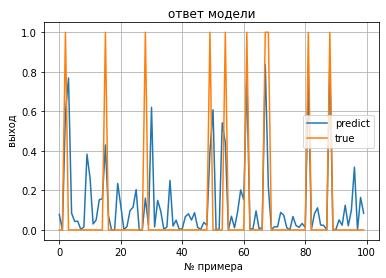

In [174]:

plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [175]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.371115, F-Score=0.665, Precision=0.701, Recall=0.633


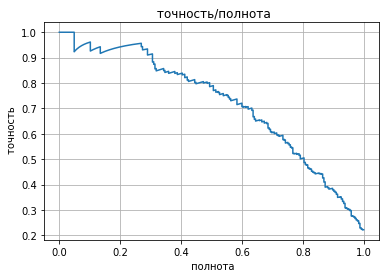

In [176]:
plt.plot(recall,precision )
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

In [177]:
import itertools

In [178]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1689   66]
 [  91  154]]


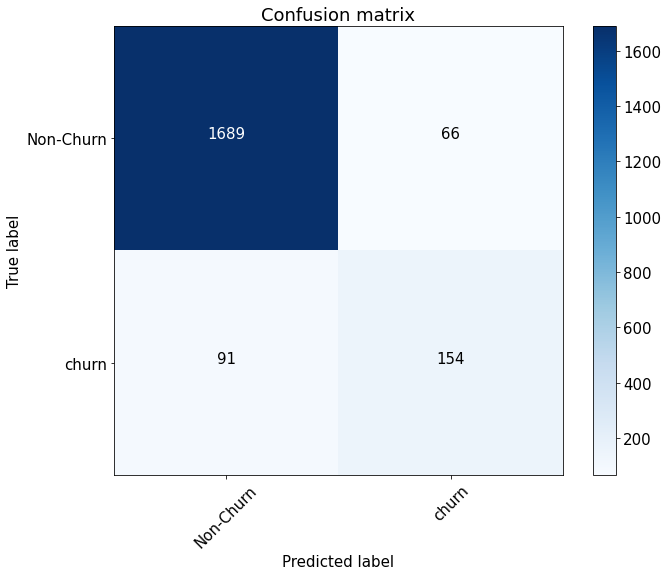

In [179]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Cо средним получилось правильно сработало 1631, неверно 68 и лишних определила модель 124    
roc_auc_score 0.9394755509041224,F-Score=0.672, Precision=0.573, Recall=0.812  

C медианой получилось лучше чем со средним True positive 1674, false negative 52, false positive 81  
roc_auc_score 0.9597604511890226, F-Score=0.734, Precision=0.710, Recall=0.759  

C max получилось лучше чем с медианой правильно 1681, неверно 62, лишних 74  
roc_auc_score 0.9340147683004825, F-Score=0.665, Precision=0.701, Recall=0.633  

In [195]:
pd.DataFrame({'metric': [',F-Score', 'Precision', 'Recall', 'Roc_Auc'], 'mean': [0.672, 0.573, 0.812, 0.939], 'median': [0.734, 0.710,0.759, 0.959],
                   'max': [0.665, 0.701, 0.633, 0.934]})


,metric,mean,median,max
0,",F-Score",0.672,0.734,0.665
1,Precision,0.573,0.710,0.701
2,Recall,0.812,0.759,0.633
3,Roc_Auc,0.939,0.959,0.934


In [180]:
roc_auc_score(y_test, preds)

0.9340147683004825

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk